# 1. Προετοιμασία δεδομένων

#### 1.0 Import τα απατούμενα packages της Python

In [48]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import re

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colormaps

import torch

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score, calinski_harabasz_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.utils import resample
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from tqdm.notebook import tqdm

from collections import Counter

from neural_network_classifier import OscarClassificationNeuralNetwork, accuracy_fn

from plotting_functions import plot_roc_curves, plot_classification_reports_averages, plot_confusion_matrices
from classifiers import build_resampled_datasets, k_fold_fit_and_test, best_f1_score_for_each_sampling_method, k_fold_fit_and_test_knn, k_fold_fit_and_test_rf

# from google.colab import drive
# drive.mount('/content/drive')
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 5. Μοντέλα προβλέψεων - τεχνικές αντιμετώπισης ανισόρροπων δεδομένων

https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/#h-3-smote

Pipiline

PCA -> Sampling methods -> training with gridsearch cv parameter searching -> classification on unknown with best achieved f1 score parameters -> final decission >=4

In [49]:
# df_un_cl.to_csv('./cleaned_dataframe_unknown.csv', index=False)
# df_cl.to_csv('./cleaned_dataframe_train.csv', index=False)

In [50]:
df_un_cl = pd.read_csv('./cleaned_dataframe_unknown.csv')
df_cl = pd.read_csv('./cleaned_dataframe_train.csv')
df_un_orig = pd.read_excel('movies_test_anon.xlsx')

In [51]:
model_results = {}

## Feature selection with PCA

### Training Dataset

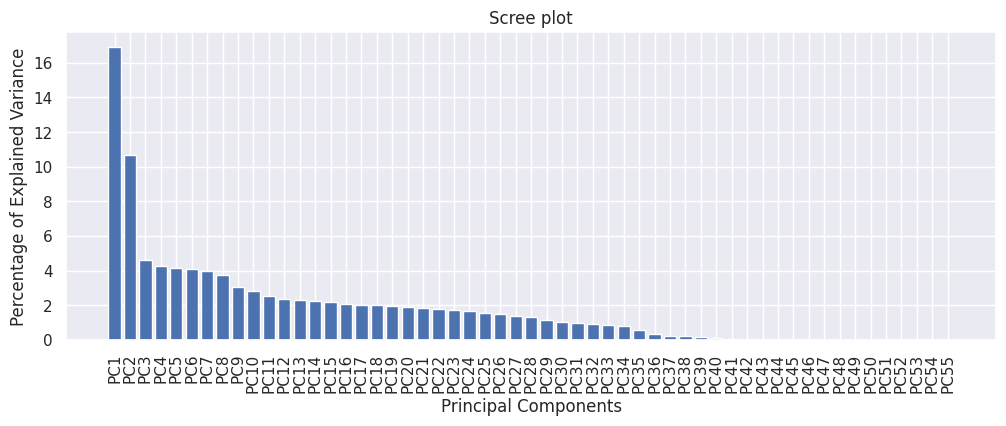

In [52]:
x = df_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail' , 'PC1', 'PC2', 'kmeans_pca', 'kmeans', 'kmeans_audience',
       'dbscan', 'agg'], axis=1)
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

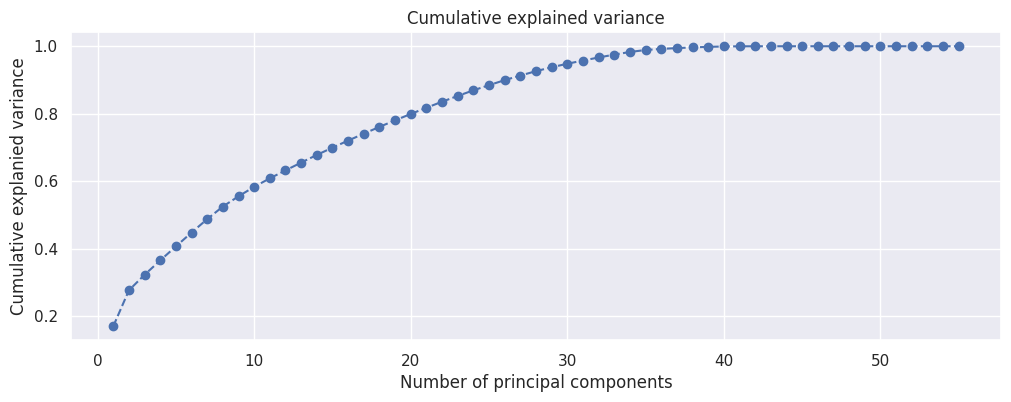

In [53]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')
plt.show()

In [54]:
# Calculate PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
df_cl = pd.concat([df_cl, principal_components_df], axis=1)

### Unknown dataset

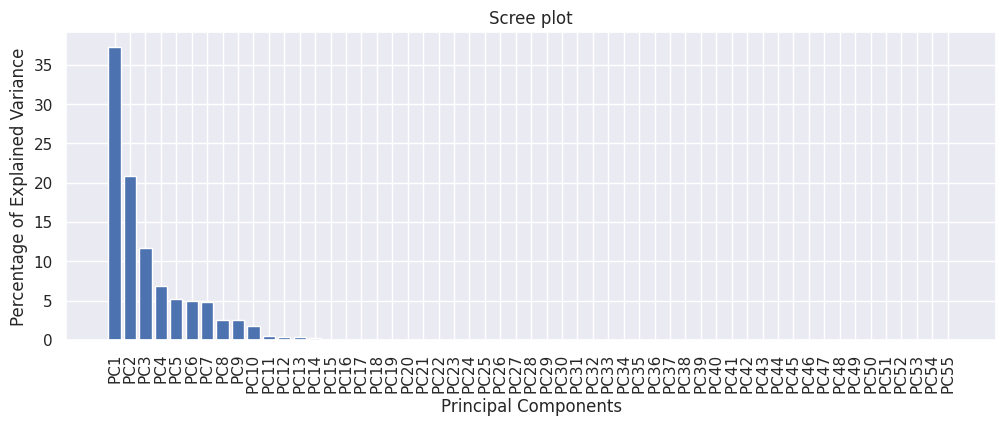

In [55]:
x = df_un_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail'], axis=1)
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

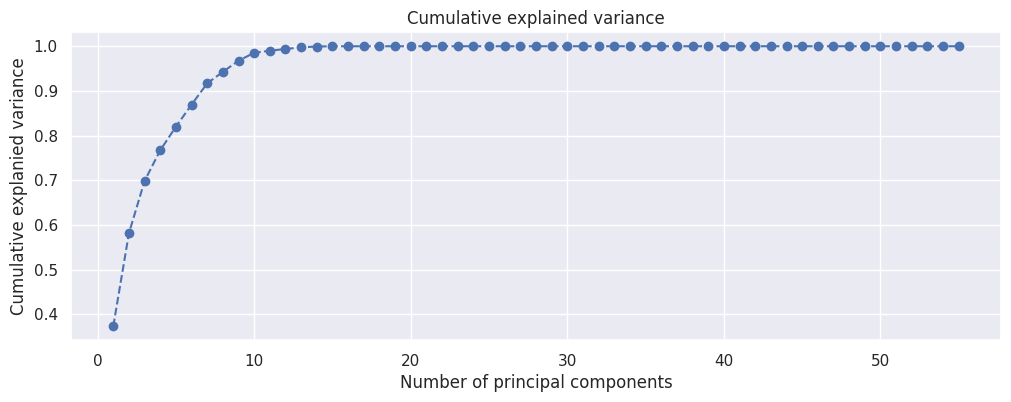

In [57]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')
plt.show()

In [59]:
# Calculate PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
df_un_cl = pd.concat([df_un_cl, principal_components_df], axis=1)

## ADA Boost

In [61]:
# df = df_cl.drop(['film','year', 'distributor','imdb_rating','imdb_vs_rt_disparity','release_date_(us)',
#                     'oscar_detail', 'PC1', 'PC2',
#        'kmeans_pca', 'kmeans', 'kmeans_audience', 'dbscan', 'agg'], axis=1)

# Select PCA components
df = df_cl[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'oscar_winners']]

# Use most correlated features

# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience', 'gen_history',
#        'domestic_gross_($million)','gen_biography','worldwide_gross_($million)','oscar_winners']]

train_datasets, test_dataset = build_resampled_datasets(df)

In [62]:
results = {}

In [75]:
#Ada boost
results['ADA'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['ADA'][sampling] = []

    model = AdaBoostClassifier(random_state=1)
    parameters = {'n_estimators': range(50, 2100, 50), 
                # 'learning_rate':[1]
                }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['ADA'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 41 candidates, totalling 205 fits
Best parameters for default: {'n_estimators': 1750}
Fitting 5 folds for each of 41 candidates, totalling 205 fits
Best parameters for upsampled: {'n_estimators': 1600}
Fitting 5 folds for each of 41 candidates, totalling 205 fits
Best parameters for downsampled: {'n_estimators': 200}
Fitting 5 folds for each of 41 candidates, totalling 205 fits
Best parameters for SMOTE: {'n_estimators': 850}


## Gradient Boost

In [33]:
# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience',
#        'opening_weekend_($million)', 'domestic_gross_($million)',
#        'foreign_gross_($million)', 'budget_($million)', 'oscar_winners']]

# train_datasets, test_dataset = build_resampled_datasets(df)

In [66]:
# Gradient boosting classifier

results['GRB'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['GRB'][sampling] = []

    model = GradientBoostingClassifier(random_state=1)

    parameters = {
        # "min_samples_split": [500],
        # "min_samples_leaf": [10],
        # "max_depth": range(1,11,2),
        # "max_features":["sqrt"],
        # "criterion": ["friedman_mse",  "mae"],
        # "subsample":[0.8],
        # 'n_estimators':range(1, 201, 2),
        'n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200],
        # "learning_rate": [0.01, 0.1, 0.4, 0.8],
        "max_depth": range(1, 6, 1)
    }


    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['GRB'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 45 candidates, totalling 225 fits


Best parameters for default: {'max_depth': 3, 'n_estimators': 200}
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters for upsampled: {'max_depth': 4, 'n_estimators': 200}
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters for downsampled: {'max_depth': 1, 'n_estimators': 1}
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters for SMOTE: {'max_depth': 4, 'n_estimators': 200}


## Decision Tree

In [67]:
# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience',
#        'opening_weekend_($million)', 'domestic_gross_($million)',
#        'foreign_gross_($million)', 'budget_($million)', 'oscar_winners']]

train_datasets, test_dataset = build_resampled_datasets(df)

In [68]:
# Decision tree classifier
results['DT'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['DT'][sampling] = []

    model = DecisionTreeClassifier(random_state=1)

    parameters = {
        "criterion": ['gini', 'entropy', 'log_loss'],
        "splitter": ['best', 'random'],
        "max_depth": range(2,11,2),
    }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['DT'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for default: {'criterion': 'gini', 'max_depth': 4, 'splitter': 'random'}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for upsampled: {'criterion': 'entropy', 'max_depth': 10, 'splitter': 'best'}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for downsampled: {'criterion': 'entropy', 'max_depth': 4, 'splitter': 'best'}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for SMOTE: {'criterion': 'entropy', 'max_depth': 8, 'splitter': 'best'}


## Random Forest

In [69]:
# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience',
#        'oscar_winners']]

# df = df_cl[['PC1', 'PC2', 'oscar_winners']]

# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience', 'domestic_gross_($million)',
#        'foreign_gross_($million)', 'oscar_winners']]

# train_datasets, test_dataset = build_resampled_datasets(df)

In [72]:
# Random forest
# model = RandomForestClassifier()
# Decision tree classifier
results['RF'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['RF'][sampling] = []

    model = RandomForestClassifier(n_jobs=-1, random_state=1)

    parameters = {
        'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'max_features':[1,3,5,7],
            #   'min_samples_leaf':[1,2,3],
            #   'min_samples_split':[1,2,3]      
  
    }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['RF'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Best parameters for default: {'max_depth': 10, 'max_features': 3, 'n_estimators': 10}
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for upsampled: {'max_depth': 10, 'max_features': 1, 'n_estimators': 100}
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for downsampled: {'max_depth': 3, 'max_features': 3, 'n_estimators': 100}
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for SMOTE: {'max_depth': None, 'max_features': 1, 'n_estimators': 200}


## K-Nearest Neighbors

Select features

In [ ]:
# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience',
#        'oscar_winners']]

# df = df_cl[['PC1', 'PC2', 'oscar_winners']]

# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience', 'domestic_gross_($million)',
#        'foreign_gross_($million)', 'oscar_winners']]

# train_datasets, test_dataset = build_resampled_datasets(df)

Train and test

In [73]:
# Random forest
# model = RandomForestClassifier()
# Decision tree classifier
results['KNN'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['KNN'][sampling] = []

    model = KNeighborsClassifier(n_jobs=-1)

    parameters = {
        "n_neighbors": range(2, 21),
        "weights": ['uniform', 'distance'],
        "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],

    }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['KNN'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 152 candidates, totalling 760 fits
Best parameters for default: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Fitting 5 folds for each of 152 candidates, totalling 760 fits
Best parameters for upsampled: {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'uniform'}
Fitting 5 folds for each of 152 candidates, totalling 760 fits
Best parameters for downsampled: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
Fitting 5 folds for each of 152 candidates, totalling 760 fits
Best parameters for SMOTE: {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'distance'}


## Plot results

Classification reports

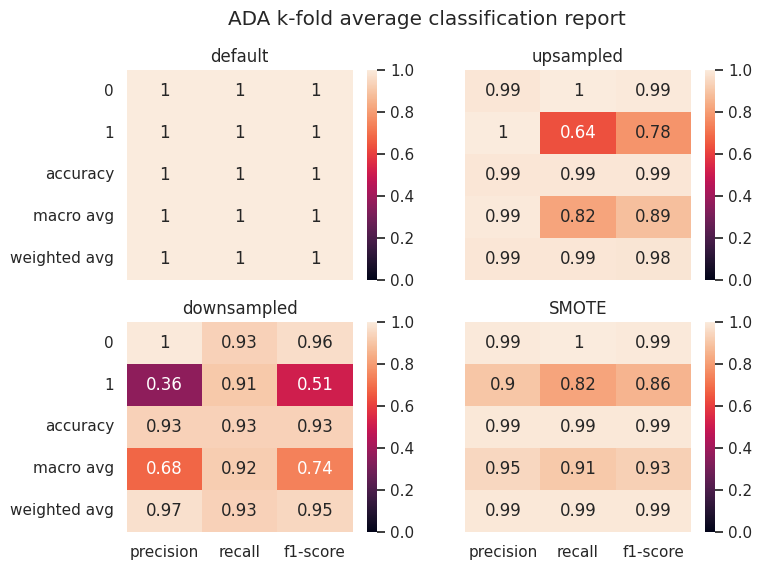

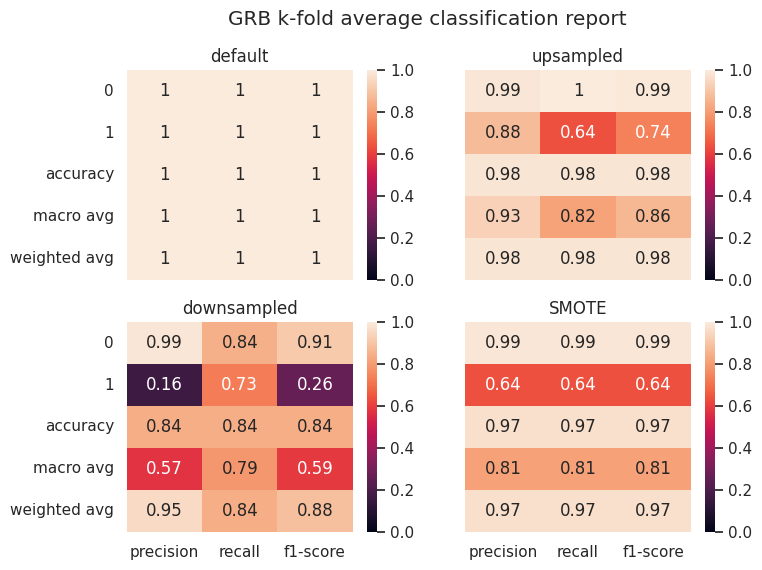

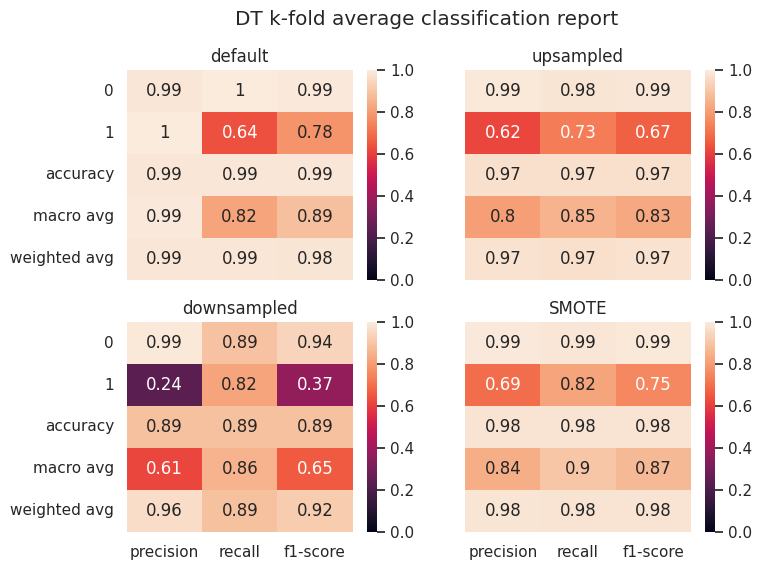

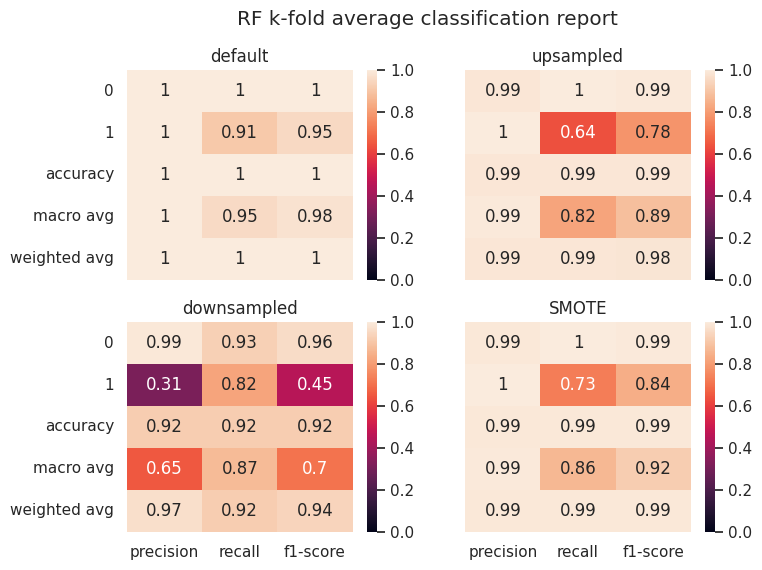

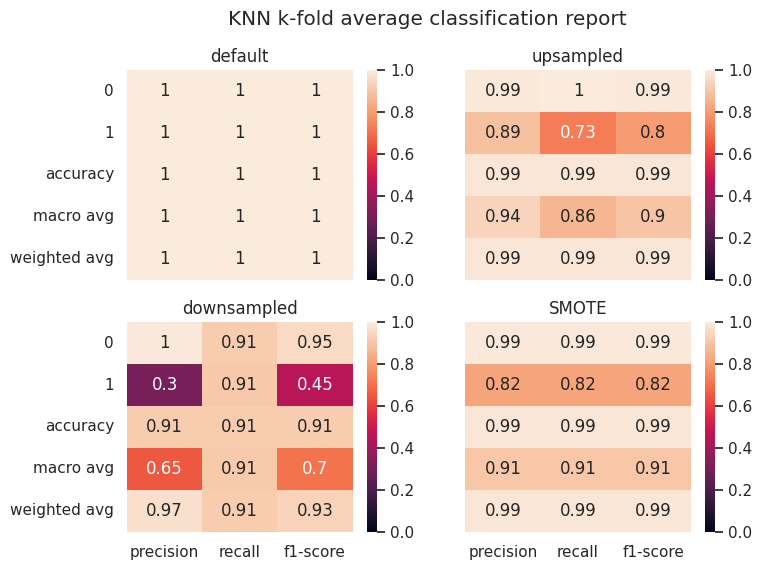

In [78]:
plot_classification_reports_averages(results, 'ADA')
plot_classification_reports_averages(results, 'GRB')
plot_classification_reports_averages(results, 'DT')
plot_classification_reports_averages(results, 'RF')
plot_classification_reports_averages(results, 'KNN')

ROC Curves

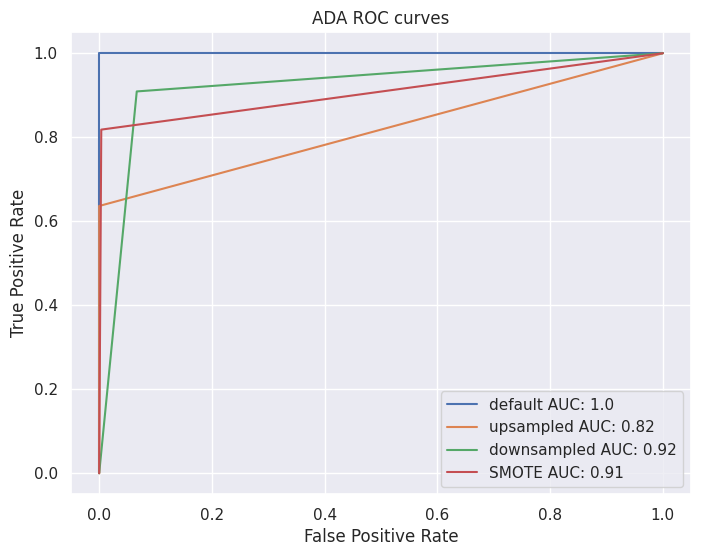

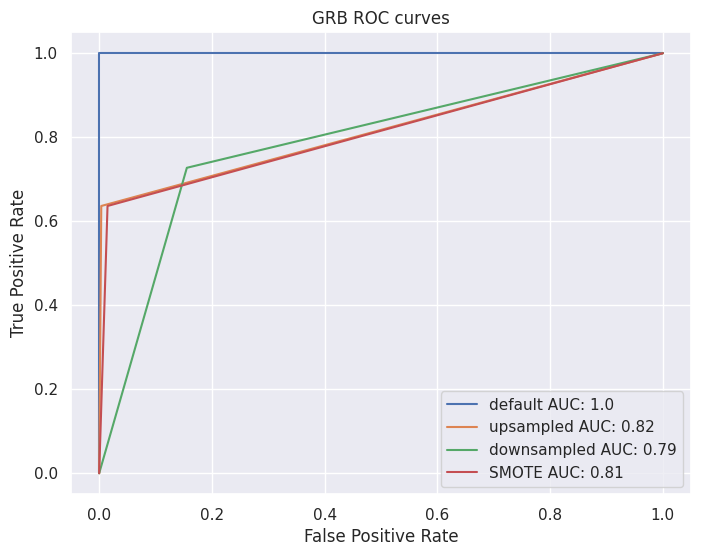

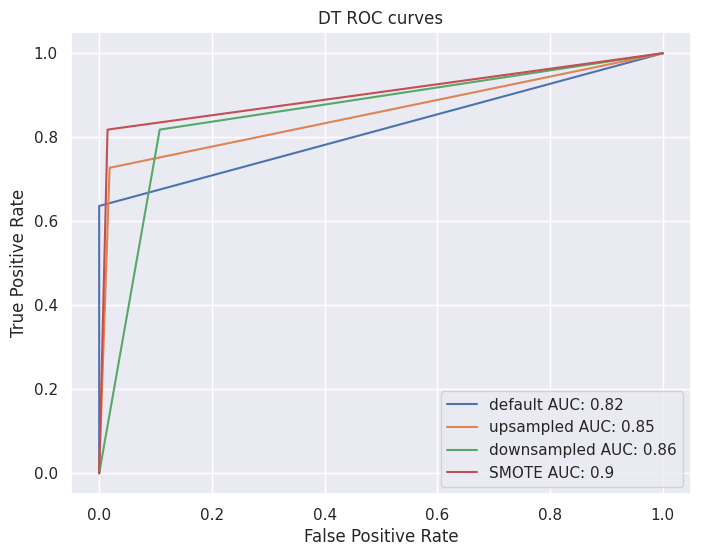

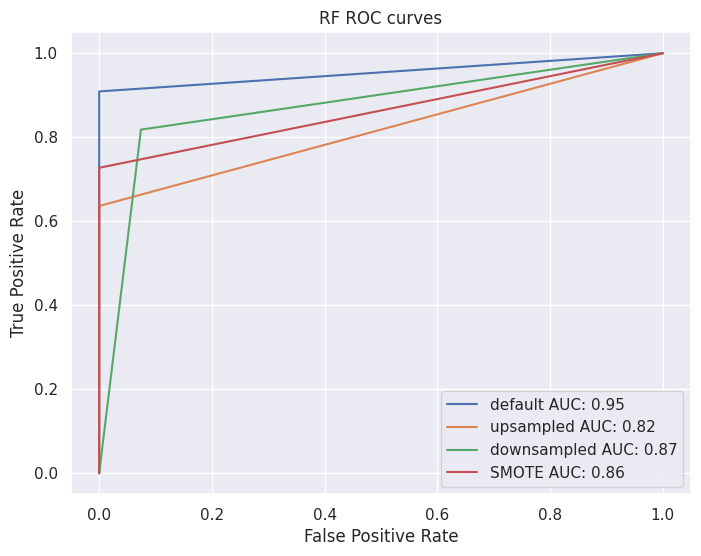

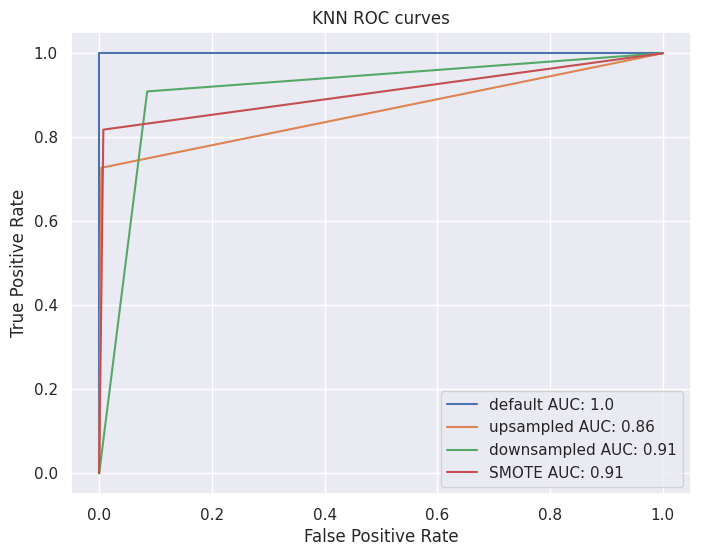

In [79]:
best_f1_ada = best_f1_score_for_each_sampling_method(results, 'ADA')
plot_roc_curves(best_f1_ada, 'ADA')
best_f1_grb = best_f1_score_for_each_sampling_method(results, 'GRB')
plot_roc_curves(best_f1_grb, 'GRB')
best_f1_dt = best_f1_score_for_each_sampling_method(results, 'DT')
plot_roc_curves(best_f1_dt, 'DT')
best_f1_rf = best_f1_score_for_each_sampling_method(results, 'RF')
plot_roc_curves(best_f1_rf, 'RF')
best_f1_knn = best_f1_score_for_each_sampling_method(results, 'KNN')
plot_roc_curves(best_f1_knn, 'KNN')

Confusion Matrices

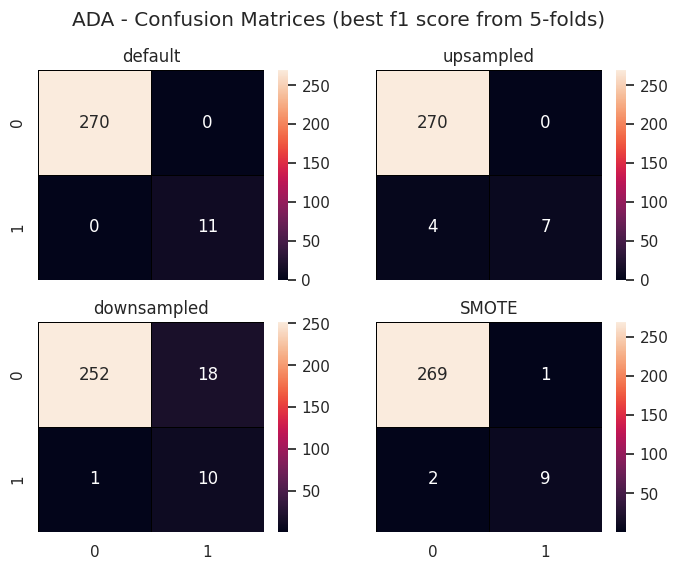

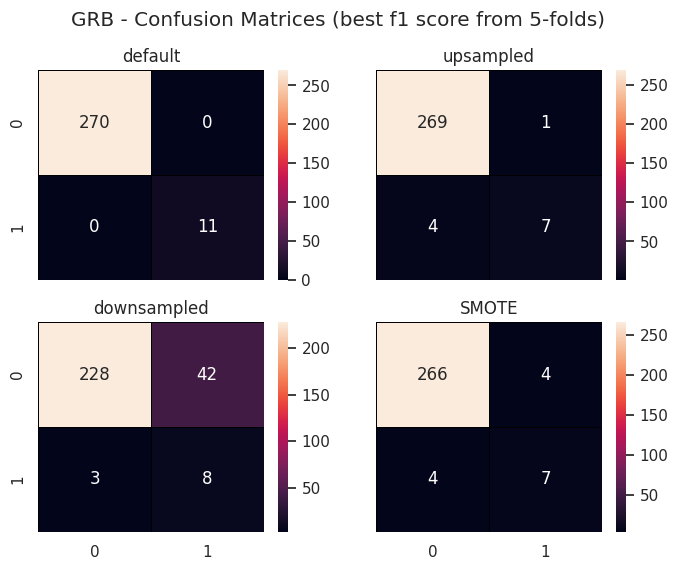

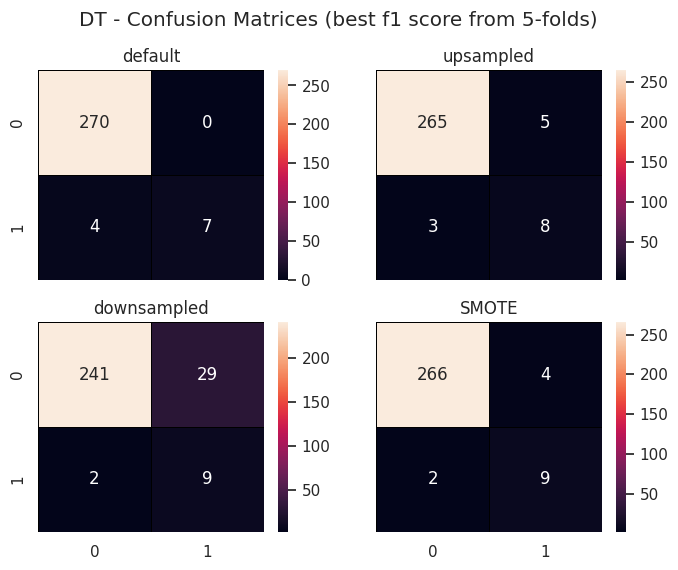

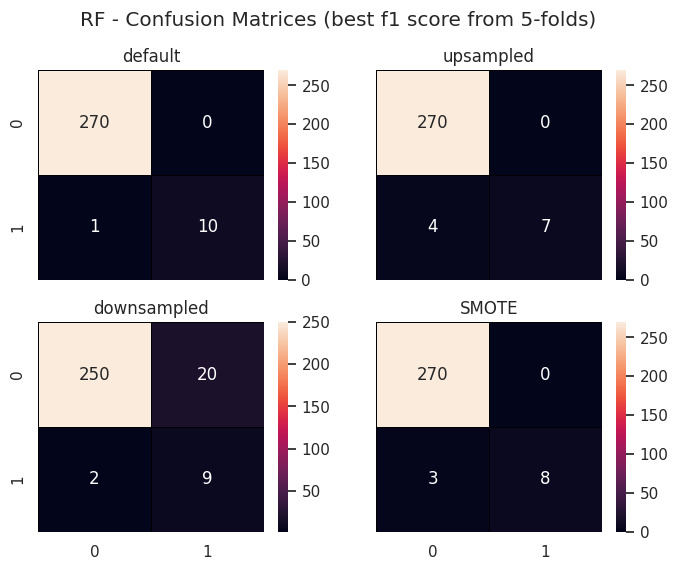

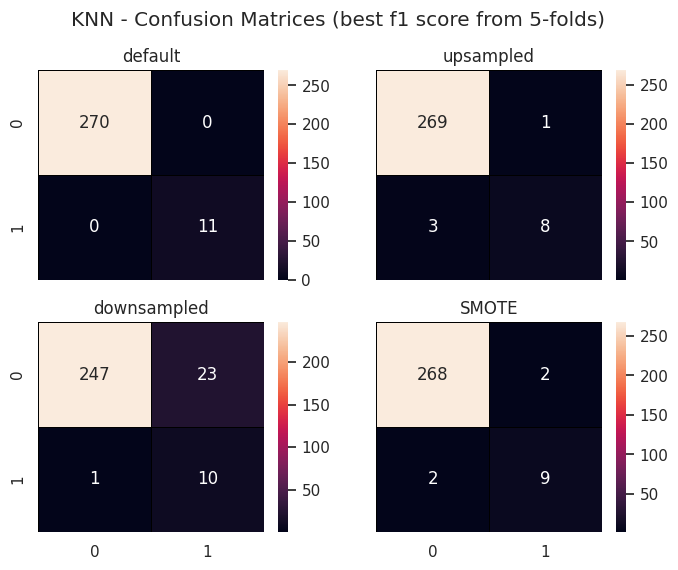

In [80]:
plot_confusion_matrices(best_f1_ada, 'ADA')
plot_confusion_matrices(best_f1_grb, 'GRB')
plot_confusion_matrices(best_f1_dt, 'DT')
plot_confusion_matrices(best_f1_rf, 'RF')
plot_confusion_matrices(best_f1_knn, 'KNN')

# 6. Predictions on unknown dataset

#### Select unknown dataset features

In [81]:
df_un_cl_predictions = df_cl[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']]
X = df_un_cl_predictions.values

### 6.1 ADA Boost

In [87]:
best_overall_ada = max(best_f1_ada.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_ada['params']

In [89]:
model = AdaBoostClassifier(**params)

model.fit(best_overall_ada['X_train'], best_overall_ada['y_train'])
un_preds = model.predict(X)

df_un_orig[f'ADA'] = pd.DataFrame(un_preds)
ada_n_predicted_oscars = len(df_un_orig[df_un_orig['ADA'] == 1])
ada_n_predicted_oscars

/home/mike/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


22

### 6.2 Gradient Boost

In [93]:
best_overall_grb = max(best_f1_grb.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_grb['params']

In [94]:
params

{'max_depth': 3, 'n_estimators': 200}

In [97]:
# best_overall_grb = max(best_f1_grb.values(), key=lambda a:a['report']['1']['f1-score'])

model = GradientBoostingClassifier(**params)

model.fit(best_overall_ada['X_train'], best_overall_ada['y_train'])
un_preds = model.predict(X)

df_un_orig[f'GRB'] = pd.DataFrame(un_preds)
grb_n_predicted_oscars= len(df_un_orig[df_un_orig['GRB'] == 1])
grb_n_predicted_oscars

/home/mike/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


22

### 6.3 Decision Tree

In [99]:
best_overall_dt = max(best_f1_dt.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_dt['params']
params

In [101]:
best_overall_dt = max(best_f1_dt.values(), key=lambda a:a['report']['1']['f1-score'])

model = DecisionTreeClassifier(**params)

# model = DecisionTreeClassifier(criterion=params['criterion'], max_depth = params['max_depth'], )

model.fit(best_overall_dt['X_train'], best_overall_dt['y_train'])
un_preds = model.predict(X)

df_un_orig[f'DT'] = pd.DataFrame(un_preds)
dt_n_predicted_oscars = len(df_un_orig[df_un_orig['DT'] == 1])
dt_n_predicted_oscars

/home/mike/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


6

### 6.4 Random Forest

In [104]:
best_overall_rf = max(best_f1_rf.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_rf['params']
params

{'max_depth': 10, 'max_features': 3, 'n_estimators': 10}

In [105]:
model = RandomForestClassifier(**params)

model.fit(best_overall_rf['X_train'], best_overall_rf['y_train'])
un_preds = model.predict(X)

df_un_orig[f'RF'] = pd.DataFrame(un_preds)
rf_n_predicted_oscars = len(df_un_orig[df_un_orig['RF'] == 1])
rf_n_predicted_oscars

/home/mike/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


20

### 6.5 K-Nearest Neighbors

In [106]:
best_overall_knn = max(best_f1_knn.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_knn['params']
params

{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}

In [107]:
model = KNeighborsClassifier(**params)
model.fit(best_overall_knn['X_train'], best_overall_knn['y_train'])

un_preds = model.predict(X)
preds_df = pd.DataFrame(un_preds)
df_un_orig[f'KNN'] = preds_df

knn_n_predicted_oscars = len(df_un_orig[df_un_orig['KNN'] == 1])
knn_n_predicted_oscars

/home/mike/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


22

## Show all model predictons

In [108]:
#['ADA', 'GRB', 'DT','RF', 'KNN']
n_oscar_preds = pd.DataFrame([[ada_n_predicted_oscars, grb_n_predicted_oscars, dt_n_predicted_oscars, rf_n_predicted_oscars, knn_n_predicted_oscars]], columns=['ADA', 'GRB', 'DT','RF', 'KNN'])

Number of predictions per model

In [109]:
n_oscar_preds

,ADA,GRB,DT,RF,KNN
0,22,22,6,20,22


Detailed predictions view

In [ ]:
# df_un_orig[(df_un_orig['ADA'] == 1) | (df_un_orig['GRB'] == 1) | (df_un_orig['DT'] == 1) | (df_un_orig['RF'] == 1) | (df_un_orig['KNN'] == 1)][['ADA', 'GRB', 'DT','RF', 'KNN']]

Select final oscar prediction criteria

In [117]:
DECISION_THRESHOLD = 4

predictions = df_un_orig[['ID', 'ADA', 'GRB', 'DT','RF', 'KNN']]
predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['GRB'] + row['DT'] + row['RF'] + row['KNN'] >= DECISION_THRESHOLD) else 0, axis=1)

/tmp/ipykernel_2942/685585381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['GRB'] + row['DT'] + row['RF'] + row['KNN'] >= DECISION_THRESHOLD) else 0, axis=1)


Overall oscar prediction number

In [118]:
len(predictions[predictions['OSCAR'] == 1])

20

In [119]:
print(f"Unkn dataset predicted oscar ratio: {len(predictions[predictions['OSCAR'] == 1]) / len(predictions) * 100:.2f}% | Testing dataset oscar prediction ratio: {len(df_cl[df_cl['oscar_winners'] == 1]) / len(df_cl) * 100:.2f}%")

Unkn dataset predicted oscar ratio: 3.54% | Testing dataset oscar prediction ratio: 3.99%


In [121]:
# Save file
# predictions.to_csv('./predictions_2.csv', index=False)